<a href="https://colab.research.google.com/github/moosemorse/AI_Text_Detector/blob/main/TATG_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [3]:
#gets rid of installation dialogue
%%capture
!pip install transformers
!pip install pytorch
!pip install datasets

In [4]:
import os
import matplotlib.pyplot as plt
from google.colab import files, drive
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
import numpy as np

In [5]:
#mount drive, gain access to file in google drive
drive.mount('/content/drive', force_remount=False)

#obtain csv file and store in var 'df' as dataframe
train_path = "drive/MyDrive/GPT-wiki-intro.csv"
df = pd.read_csv(train_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Inspect data

In [ ]:
#data to describe csv file
print(df.describe())

                 id      title_len  wiki_intro_len  generated_intro_len  \
count  1.500000e+05  150000.000000   150000.000000        150000.000000   
mean   2.498393e+07       2.215380      196.005113           129.469147   
std    2.143867e+07       0.629514       41.444268            57.040399   
min    3.050000e+02       1.000000      150.000000             7.000000   
25%    4.431408e+06       2.000000      164.000000            86.000000   
50%    2.072982e+07       2.000000      184.000000           122.000000   
75%    4.231795e+07       3.000000      216.000000           170.000000   
max    7.020174e+07       3.000000      350.000000           278.000000   

       prompt_tokens  generated_text_tokens  
count  150000.000000          150000.000000  
mean       28.957760             165.740753  
std         5.045038              77.221271  
min        21.000000               1.000000  
25%        26.000000             107.000000  
50%        28.000000             155.000000  
75

In [6]:
df.head()

,id,url,title,wiki_intro,generated_intro,title_len,wiki_intro_len,generated_intro_len,prompt,generated_text,prompt_tokens,generated_text_tokens
0,63064638,https://en.wikipedia.org/wiki/Sexhow%20railway...,Sexhow railway station,Sexhow railway station was a railway station b...,Sexhow railway station was a railway station l...,3,174,78,200 word wikipedia style introduction on 'Sexh...,"located in the town of Sexhow, on the Cumbria...",25,88
1,279621,https://en.wikipedia.org/wiki/Eti%C3%A4inen,Etiäinen,"In Finnish folklore, all places and things, an...","In Finnish folklore, all places and things, an...",1,187,80,200 word wikipedia style introduction on 'Etiä...,"animate or inanimate, have a spirit or ""etiäi...",26,101
2,287229,https://en.wikipedia.org/wiki/Inverse%20functi...,Inverse function theorem,"In mathematics, specifically differential calc...","In mathematics, specifically differential calc...",3,170,59,200 word wikipedia style introduction on 'Inve...,function theorem states that for every real-v...,26,65
3,26712375,https://en.wikipedia.org/wiki/Stepping%20on%20...,Stepping on Roses,is a Japanese shōjo manga series written and i...,is a Japanese shōjo manga series written and i...,3,335,121,200 word wikipedia style introduction on 'Step...,and illustrated by Maki Fujii. The series fol...,26,150
4,38894426,https://en.wikipedia.org/wiki/Rob%20Bradley,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...","Robert Milner ""Rob"" Bradley, Jr. (born August ...",2,170,136,200 word wikipedia style introduction on 'Rob ...,"29, 1973) is an American former professional ...",28,162


In [23]:
print(df.iloc[0:3].loc[:, ['url', 'title']])
#iloc dictates the rows indexed
#loc dictates the columns extracted

                                                 url                     title
0  https://en.wikipedia.org/wiki/Sexhow%20railway...    Sexhow railway station
1        https://en.wikipedia.org/wiki/Eti%C3%A4inen                  Etiäinen
2  https://en.wikipedia.org/wiki/Inverse%20functi...  Inverse function theorem


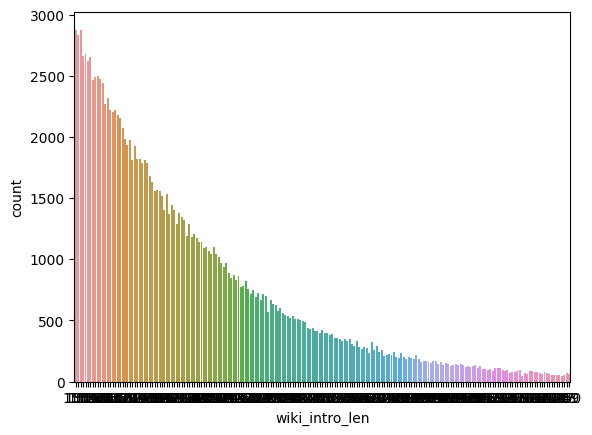

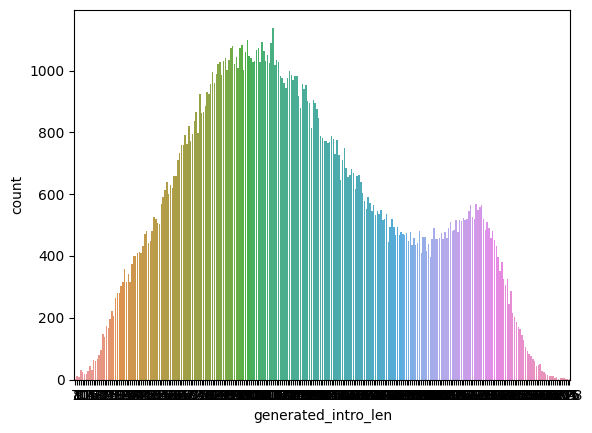

In [ ]:
#visualisation to compare data for human-written text and ai-written text
#testing seaborn and these could be helpful for evaluation afterwards
sns.countplot(x = 'wiki_intro_len', data = df)
plt.show()

sns.countplot(x = 'generated_intro_len', data = df)
plt.show()

# Dataset

In [ ]:
#dataset class inherits dataset module imported from torch
class ChatGPT_Dataset(Dataset):

  def __init__(self, data_path, tokenizer, labels, max_token_len = 512):
    self.labels = labels
    self.data_path = data_path
    self.tokenizer = tokenizer
    self.labels = labels
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    label = self.labels[idx]


In [ ]:
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name) #use pretrained tokenizer used from Roberta
ChatGPT_ds = ChatGPT_Dataset(df, tokenizer, attributes) #instance of dataset


# Creating the model

# Evaluating the model